In [2]:
import os, operator, itertools
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.formula.api as sm

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import nltk, string, os
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(0)

In [3]:
from Axe_Object import Axe

In [4]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [5]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price > 110 and this_axe.price < 800:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [6]:
len(axes)

10025

In [9]:
prices = pd.Series([axe.price for axe in axes], name = 'prices')

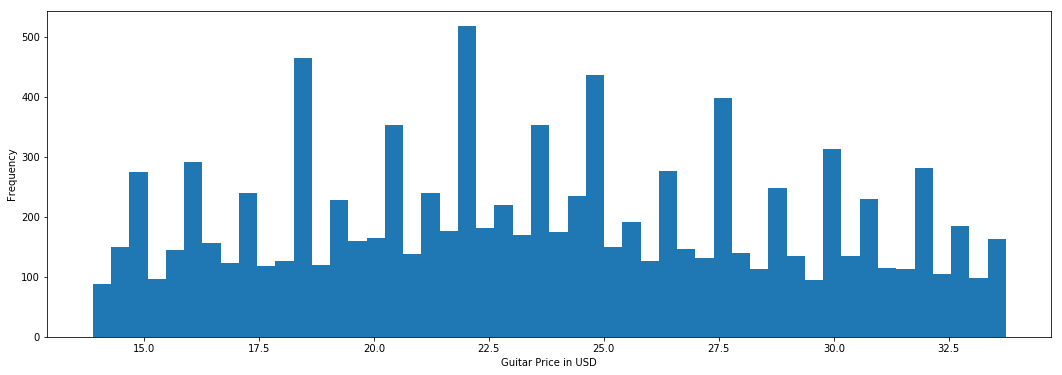

In [16]:
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

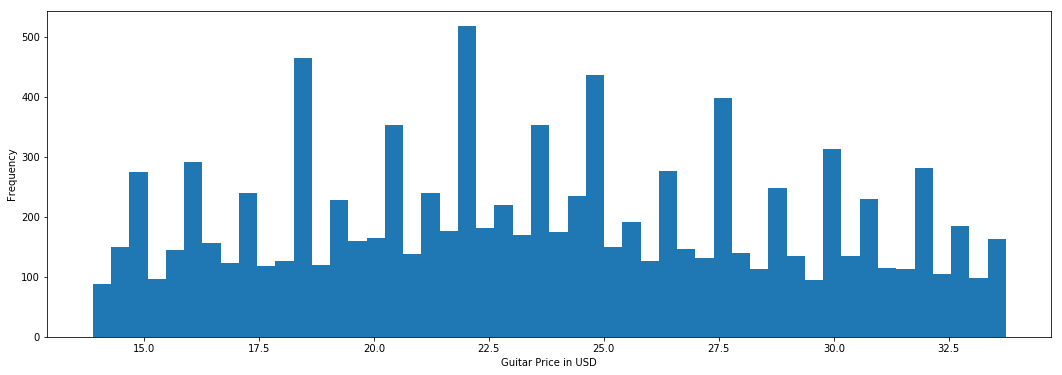

In [17]:
bxcx_lam = .4
prices = pd.Series(boxcox([axe.price for axe in axes], lmbda=bxcx_lam), name = 'prices')
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

In [19]:
auction_duration    = pd.Series([axe.duration for axe in axes], name = 'auction_duration')
shipping_charged    = pd.Series([axe.price_shipping for axe in axes], name = 'shipping_charged')
seller_country      = pd.Series([axe.country_seller for axe in axes], name = 'seller_country')
autopay             = pd.Series([axe.autopay for axe in axes], name = 'autopay')
returns             = pd.Series([axe.returns for axe in axes], name = 'returns')
listing_type        = pd.Series([axe.listing_type for axe in axes], name = 'listing_type')
ship_type           = pd.Series([axe.ship_type for axe in axes], name = 'ship_type')
ship_expedite       = pd.Series([axe.ship_expedite for axe in axes], name = 'ship_expedite')
start_hour          = pd.cut(pd.Series([axe.start_time.hour for axe in axes], name = 'start_hour'), 6)
end_hour            = pd.cut(pd.Series([axe.end_time.hour for axe in axes], name = 'end_hour'), 6)
start_weekday       = pd.Series([axe.start_weekday for axe in axes], name = 'start_weekday').astype('category')
end_weekday         = pd.Series([axe.end_weekday for axe in axes], name = 'end_weekday').astype('category')
returns_time        = pd.Series([axe.returns_time for axe in axes], name = "returns_time").astype('category')
num_pics            = pd.Series([axe.pic_quantity for axe in axes], name = "num_pics")
brand               = pd.Series([axe.brand for axe in axes], name = "brand")
body_type           = pd.Series([axe.body_type for axe in axes], name = "body_type")
color               = pd.Series([axe.color for axe in axes], name = "color")
right_left_handed   = pd.Series([axe.right_left_handed for axe in axes], name = "right_left_handed")
best_offer_enabled  = pd.Series([axe.best_offer_enabled for axe in axes], name = "best_offer_enabled")
country_manufacture = pd.Series([axe.country_manufacture for axe in axes], name = "country_manufacture")

ship_handling_time = pd.Series([axe.ship_handling_time for axe in axes], name = 'ship_handling_time').astype('category')

string_config = pd.cut(pd.Series([axe.string_config for axe in axes], name = "string_config"),
                       [0,5,6,11,20])

seller_feedback_score = pd.cut(pd.Series([axe.seller_feedback_score for axe in axes], name = "seller_feedback_score"), [-411,0,50,100,200,500,750,1250,2500,10000,100000,400000])

seller_positive_percent = pd.cut(pd.Series([axe.seller_positive_percent for axe in axes], name = "seller_positive_percent"), [-10000,99.5,111])

model_year = pd.cut(pd.Series([axe.year for axe in axes], name = "model_year"), [1700,1975,1990,1995,2000,2005,2007,2010,2011,2012,2013,2015])

## Text as a Regression Feature

http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf

In [20]:
def assemble_guitar_document(axe):
    document = axe.title + ' '
    if axe.year != None:
        document += (str(axe.year) + ' ')
    if axe.material != None:
        document += axe.material + ' '
    if axe.model != None:
        document += axe.model + ' ' 
    if axe.brand != None:
        document += axe.brand + ' '
    if axe.subtitle != None:
        document += axe.subtitle + ' '
    if axe.condition_description != None:
        document += axe.condition_description + ' '
    if axe.description != None:
        document += axe.description
    return document

In [21]:
raw_corpus = [assemble_guitar_document(axe).lower() for axe in axes]

In [22]:
stemmer = SnowballStemmer("english")

In [23]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', ",", ".", ":", "'s", "--","’"]

In [24]:
def process_doc(doc):
    stopwords_removed = ''
    tokens = nltk.word_tokenize(doc)
    for i in range(len(tokens)):
        if tokens[i].lower() not in stopwords_list and tokens[i] not in string.punctuation:
            stopwords_removed += stemmer.stem(tokens[i]) + ' '
    return stopwords_removed

In [25]:
processed_data = list(map(process_doc, raw_corpus))

In [47]:
vectorizer = TfidfVectorizer(norm=None, ngram_range=(2,2), strip_accents='ascii',
#                             max_df=0.8, min_df=2,
                             max_features=200)
tfidf = vectorizer.fit_transform(processed_data)
tfidf_array = tfidf.toarray()

In [48]:
tfidf_df = pd.DataFrame(tfidf_array, columns=vectorizer.get_feature_names())

In [49]:
tfidf_df.shape

(10025, 200)

***

**Assemble the Feature Set**

In [50]:
X_no_dummies = pd.concat([prices, brand, color, country_manufacture, right_left_handed, best_offer_enabled, shipping_charged, 
               returns, returns_time, autopay,seller_country, ship_handling_time, listing_type, ship_expedite,
               ship_type, num_pics, auction_duration, start_hour, end_hour, start_weekday, end_weekday, 
               seller_feedback_score, seller_positive_percent, model_year, body_type, string_config,
                          tfidf_df],
#              LDA_topic_weights],
              axis = 1)

y_X = pd.get_dummies(X_no_dummies, drop_first=True)

In [51]:
len(y_X.columns)

330

### Feature Pruning

Removing Colinear Features:

In [52]:
corr = y_X.iloc[:,1:].corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = y_X.iloc[:,1:].columns[columns]
X = y_X.iloc[:,1:][selected_columns]

In [53]:
X.head()

,best_offer_enabled,shipping_charged,returns,autopay,ship_expedite,num_pics,auction_duration,14 day,30 day,48 state,accept paypal,actual item,addit cost,amp amp,amp gt,ask question,auction end,bodi electr,bodi neck,brand new,bridg pickup,busi day,buyer pay,buyer pleas,buyer respons,case includ,charg buyer,charg includ,coil pickup,combin ship,condit guitar,condit use,contact us,cost ship,custom shop,day auction,day payment,day return,describ item,duti tax,ebay ship,electr guitar,electron work,epiphon les,esp ltd,excel condit,feel free,fender squier,fender stratocast,flame mapl,floyd rose,free ask,free ship,fret wear,gibson les,gig bag,good condit,good luck,great condit,great guitar,great shape,guitar black,guitar case,guitar come,guitar excel,guitar good,guitar great,guitar made,guitar play,guitar use,hard case,hard shell,hardshel case,hollow bodi,humbuck pickup,import duti,includ item,includ ship,intern buyer,intern ship,item descript,item must,item pleas,item receiv,item sale,item ship,jumbo fret,left hand,les paul,light scratch,like new,limit edit,local pickup,lock tuner,look pictur,low action,lower 48,made japan,made mexico,mahogani bodi,mahogani neck,make payment,make sure,mapl neck,mapl top,master volum,medium jumbo,mint condit,money back,neck pickup,neck straight,new condit,new string,nut width,packag ship,paul standard,paul studio,pay ship,payment receiv,pick guard,pick up,pickup posit,pickup switch,play great,play sound,pleas ask,pleas check,pleas contact,pleas feel,pleas make,pleas note,pleas read,pleas see,pre own,prior bidding,prioriti mail,puerto rico,question pleas,receiv item,reserv right,restock fee,return item,return polici,return ship,right hand,rosewood fingerboard,rosewood fretboard,sale final,sale tax,scale length,see photo,see pic,see pictur,semi hollow,serial number,set neck,seymour duncan,ship address,ship charg,ship cost,ship fee,ship insur,ship intern,ship item,ship lower,ship ship,ship within,singl coil,single coil,soft case,solid bodi,solid wood,solidbodi electr,sound great,standard stratocast,stratocast fender,string electr,thank look,tone control,truss rod,unit state,use condit,use guitar,vintage styl,volum tone,way switch,within busi,within day,work condit,would like,brand_CHARVEL,brand_DEAN,brand_EPIPHONE,brand_ESP,brand_FENDER,brand_G&L,brand_GIBSON,brand_GRETSCH,brand_IBANEZ,brand_JACKSON,brand_OTHER,brand_PEAVEY,brand_PRS,brand_RICKENBACKER,brand_SCHECTER,brand_SQUIER,brand_WASHBURN,brand_YAMAHA,color_BLUE,color_GREEN,color_NATURAL,color_OTHER,color_RED,color_SUNBURST,color_WHITE,color_YELLOW,country_manufacture_CHINA,country_manufacture_COLOMBIA,country_manufacture_FRANCE,country_manufacture_GEORGIA,country_manufacture_GERMANY,country_manufacture_INDIA,country_manufacture_INDONESIA,country_manufacture_ISRAEL,country_manufacture_ITALY,country_manufacture_JAPAN,country_manufacture_KOREA,country_manufacture_MEXICO,country_manufacture_N/A,country_manufacture_RUSSIAN FEDERATION,country_manufacture_SAINT HELENA,country_manufacture_SWEDEN,country_manufacture_SWITZERLAND,country_manufacture_TAIWAN,country_manufacture_UKRAINE,country_manufacture_UNITED KINGDOM,country_manufacture_UNKNOWN,country_manufacture_USA,country_manufacture_VIETNAM,right_left_handed_RIGHT,returns_time_14,returns_time_30,returns_time_60,seller_country_GB,seller_country_JP,seller_country_OTHER,seller_country_US,ship_handling_time_1,ship_handling_time_2,ship_handling_time_3,ship_handling_time_4,ship_handling_time_5,ship_handling_time_10,ship_handling_time_15,listing_type_FixedPrice,listing_type_StoreInventory,ship_type_CalculatedDomesticFlatInternational,ship_type_Flat,ship_type_FlatDomesticCalculatedInternational,ship_type_Free,ship_type_FreePickup,ship_type_Freight,"start_hour_(3.833, 7.667]","start_hour_(7.667, 11.5]","start_hour_(11.5, 15.333]","start_hour_(15.333, 19.167]","start_hour_(19.167, 23.0]","end_hour_(3.833, 7.667]","end_hour_(7.667, 11.5]","end_hour_(11.5, 15.333]","end_hour_(15.333, 19.167]","end_hour_(19.167, 23.

In [54]:
len(X), len(X.columns)

(10025, 312)

### Preprocessing

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y_X.iloc[:,0], test_size=.2)#, random_state=42)

In [224]:
scaler = StandardScaler()

In [225]:
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled  = scaler.transform(X_test)

C:\Users\rob\AppData\Local\conda\conda\envs\Bayes\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rob\AppData\Local\conda\conda\envs\Bayes\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\rob\AppData\Local\conda\conda\envs\Bayes\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  


### Baseline Naive Error - Guess the Mean Price

In [237]:
price_mean = np.mean(y_train)
price_mean_vector = inv_boxcox([price_mean for i in range(len(y_test))],bxcx_lam)
baseline_error = np.sqrt(mean_squared_error(inv_boxcox(y_test, bxcx_lam), price_mean_vector))
baseline_error

184.68098926497973

### Lasso Regression

In [256]:
# alphas = np.logspace(-4, -0.5, 30)
lin_reg = LassoCV(cv=5).fit(X_train_scaled, y_train)

In [257]:
y_train_preds = lin_reg.predict(X_train_scaled)
y_test_preds = lin_reg.predict(X_test_scaled)

In [258]:
y_train_inv = inv_boxcox(y_train, bxcx_lam)
y_test_inv = inv_boxcox(y_test, bxcx_lam)
y_train_preds_inv = inv_boxcox(y_train_preds, bxcx_lam)
y_test_preds_inv = inv_boxcox(y_test_preds, bxcx_lam)

In [259]:
train_error = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv))
test_error = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv))
(train_error, test_error)

(148.75833497097494, 152.94211357206976)

In [260]:
print(f'Train error is a {round((((baseline_error - train_error) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'Test error is a {round((((baseline_error - test_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

Train error is a 19.45% improvement over guessing the mean. 

Test error is a 17.19% improvement over guessing the mean.


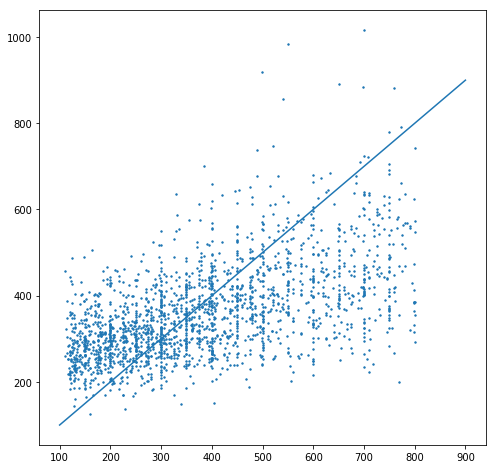

In [261]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv, s=2)
x = np.linspace(100,900, num=2)
plt.plot(x,x)
plt.show()

Can I get a confusion matrix?

In [262]:
thresh = 500

In [263]:
high_value_guitars = y_test_inv > thresh
sum(high_value_guitars)

498

In [264]:
high_value_guesses = y_test_preds_inv > thresh
sum(high_value_guesses)

200

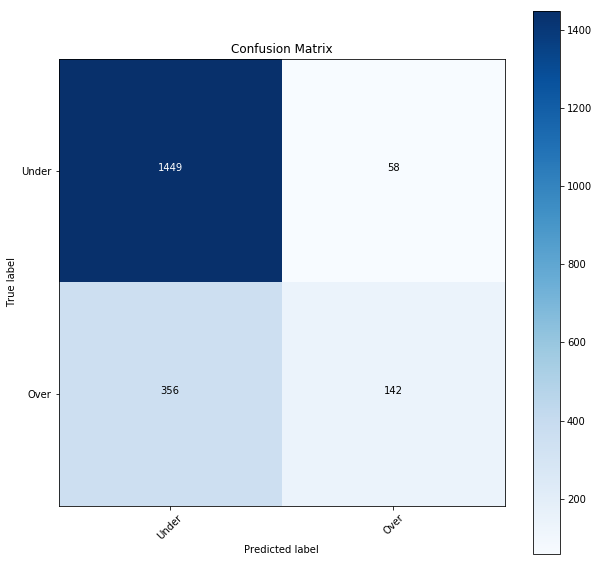

In [265]:
plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(high_value_guitars, high_value_guesses)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Under', 'Over'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()
plt.show()

We're trying to avoid false positives more than false negatives.

Now let's try to have it predict on a new guitar.

In [255]:
X_test.iloc[0,:]

best_offer_enabled                          False
shipping_charged                               28
returns                                     False
autopay                                     False
ship_expedite                               False
num_pics                                       12
auction_duration                                0
14 day                                          0
30 day                                          0
48 state                                        0
accept paypal                                   0
actual item                                     0
addit cost                                      0
amp amp                                         0
amp gt                                          0
ask question                                    0
auction end                                     0
bodi electr                                     0
bodi neck                                       0
brand new                                       0


In [251]:
new_datapoint = 

In [252]:
lin_reg.predict(new_datapoint)

ValueError: Expected 2D array, got 1D array instead:
array=[1 3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Cheap image analysis - white balance?
# Transfer learning on quality of image
# Present Insights about time of day / day of week